In [30]:
import nltk as nltk
import nltk.corpus  
from nltk.text import Text
from nltk.corpus import stopwords
import pandas as pd
import re
import sys
import matplotlib.pyplot as plt
import numpy as np
import scikitplot as skplt
import glob
import os
import spacy
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn import metrics, utils, tree
from sklearn.neural_network import MLPClassifier

In [5]:
data = pd.read_csv("Z:/final_data/all_findings_data.csv",keep_default_na=False)

In [6]:
data.head()

,Unnamed: 0,patient_id,ild_status,all_findings_cleaned
0,0,99,0,lung nodule previously visualize right lateral...
1,1,104,0,unenhanced head ct : detectable acute intracra...
2,2,149,0,chronic pulmonary opacity possibly partly calc...
3,3,195,0,stable mild prominence mediastinum . cardiac /...
4,4,208,0,unremarkable cardiac mediastinal silhouette . ...


In [7]:
data = data[['patient_id', 'all_findings_cleaned', 'ild_status']]

In [8]:
# check on class sizes

len(data[data['ild_status']==1])/len(data)

0.026591692363504445

In [10]:
len(data[data['ild_status']==1])

2199

In [12]:
# Separate majority and minority classes
df_majority = data[data['ild_status']==0]
df_minority = data[data['ild_status']==1]
 
# Upsample minority class
df_minority_upsampled = utils.resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=len(data[data['ild_status']==0]),    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled['ild_status'].value_counts()

1    80496
0    80496
Name: ild_status, dtype: int64

In [13]:
X = np.array(df_upsampled['all_findings_cleaned'])
Y = np.array(df_upsampled['ild_status'])
print(X.shape)
print(Y.shape)

(160992,)
(160992,)


In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,random_state=1)
print(X_train.shape)
print(Y_train.shape)


(120744,)
(120744,)


In [15]:
vect = CountVectorizer()
vect.fit(X_train)
%time X_train_dtm = vect.transform(X_train)


Wall time: 40.1 s


In [16]:
# test
X_test_dtm = vect.transform(np.array(X_test))
X_test_dtm


<40248x23655 sparse matrix of type '<class 'numpy.int64'>'
	with 4626888 stored elements in Compressed Sparse Row format>

### Logit 

In [19]:
logit = LogisticRegression()
%time logit.fit(X_train_dtm, Y_train)

Wall time: 10min 34s


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [20]:
y_pred_logit = logit.predict(X_test_dtm)
print('Logit predictive accuracy: {:.2f}'.format(logit.score(X_test_dtm, Y_test)))

Logit predictive accuracy: 0.91


In [22]:
# calculate accuracy of class predictions
print(metrics.accuracy_score(Y_test, y_pred_logit))

0.9052126813754721


In [23]:
# calculate precision and recall
print(classification_report(Y_test, y_pred_logit))

# calculate the confusion matrix
logit_conf_mat = metrics.confusion_matrix(Y_test, y_pred_logit)
print(logit_conf_mat)


             precision    recall  f1-score   support

          0       0.92      0.89      0.90     20235
          1       0.89      0.93      0.91     20013

avg / total       0.91      0.91      0.91     40248

[[17918  2317]
 [ 1498 18515]]


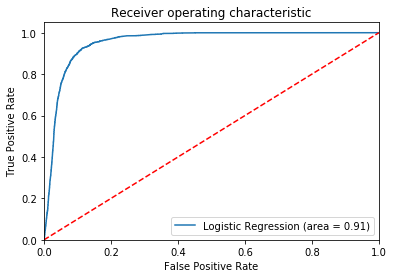

In [24]:
logit_roc_auc = metrics.roc_auc_score(Y_test, y_pred_logit)
fpr_logit, tpr_logit, thresholds_logit = metrics.roc_curve(Y_test, logit.predict_proba(X_test_dtm)[:,1])
plt.figure()
plt.plot(fpr_logit, tpr_logit, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

### Decision Tree

In [26]:
dt = tree.DecisionTreeClassifier()
%time dt = dt.fit(X_train_dtm, Y_train)

Wall time: 3min 47s


In [27]:
y_pred_dt = dt.predict(X_test_dtm)
print('Decision tree predictive accuracy: {:.2f}'.format(dt.score(X_test_dtm, Y_test)))

Decision tree predictive accuracy: 0.97


In [28]:
# calculate precision and recall
print(classification_report(Y_test, y_pred_dt))

# calculate the confusion matrix
dt_conf_mat = metrics.confusion_matrix(Y_test, y_pred_dt)
print(dt_conf_mat)

             precision    recall  f1-score   support

          0       0.99      0.95      0.97     20235
          1       0.95      0.99      0.97     20013

avg / total       0.97      0.97      0.97     40248

[[19259   976]
 [  203 19810]]


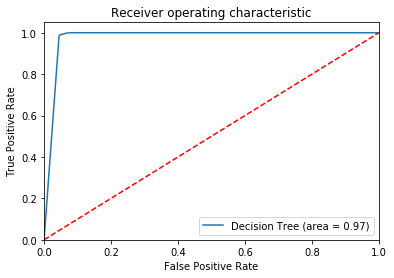

In [29]:
dt_roc_auc = metrics.roc_auc_score(Y_test, y_pred_dt)
fpr_dt, tpr_dt, thresholds_dt = metrics.roc_curve(Y_test, dt.predict_proba(X_test_dtm)[:,1])
plt.figure()
plt.plot(fpr_dt, tpr_dt, label='Decision Tree (area = %0.2f)' % dt_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('DT_ROC')
plt.show()

### Neural Net

In [31]:
mlp = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1)

In [32]:
%time mlp.fit(X_train_dtm, Y_train)

Wall time: 3min 23s


MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [33]:
y_pred_mlp = mlp.predict(X_test_dtm)
print('MLP Upsampled predictive accuracy: {:.2f}'.format(mlp.score(X_test_dtm, Y_test)))

MLP Upsampled predictive accuracy: 0.89


In [36]:
# calculate precision and recall
print(classification_report(Y_test, y_pred_mlp))

# calculate the confusion matrix
mlp_us_conf_mat = metrics.confusion_matrix(Y_test, y_pred_mlp)
print(mlp_us_conf_mat)

             precision    recall  f1-score   support

          0       0.96      0.83      0.89     20235
          1       0.85      0.96      0.90     20013

avg / total       0.90      0.89      0.89     40248

[[16762  3473]
 [  763 19250]]


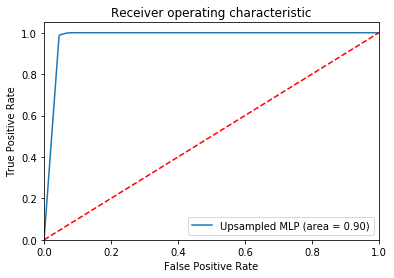

In [38]:
mlp_us_roc_auc = metrics.roc_auc_score(Y_test, y_pred_mlp)
fpr_mlp, tpr_mlp, thresholds_mlp = metrics.roc_curve(
    Y_test, mlp.predict_proba(X_test_dtm)[:,1])
plt.figure()
plt.plot(fpr_dt, tpr_dt, label='Upsampled MLP (area = %0.2f)' % mlp_us_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Upsampled_MLP_ROC')
plt.show()